# Receive Renovar API Data

## Constants

### Sensors IDs

In [1]:
TEMPERATURE_ID     =  130
PRESSURE_ID        =  131
ALPHA_CO_ID        =  132
ALPHA_NO2_ID       =  133
ALPHA_SO2_1_ID     =  134
ALPHA_OX_1_ID      =  135
ALPHA_OX_2_ID      =  136
ALPHA_SO2_2_ID     =  137
EXT_TEMPERATURE_ID =  138
EXT_HUMIDITY_ID    =  139
PM10_ID            =  140
PM25_ID            =  141
PM01_ID            =  142
OPC_TEMPERATURE_ID =  143
OPC_HUMIDITY_ID    =  144

### API Constants

In [2]:
HOST = "renovar.lcqar.ufsc.br"
PORT = 8080
GET_SAMPLES_BY_SENSOR = "/sample/sensor/all/"
HTTP_REQUEST_MAIN = 'http://' + HOST + ':' + str(PORT) + GET_SAMPLES_BY_SENSOR

### Methods for creating and processing requests

In [3]:
import requests
import json
import pandas as pd
import numpy as np

class GetSensorDataService:
    def __init__(self, host, port, endpoint) -> None:
        self.__endpoint = 'http://' + host + ':' + str(port) + endpoint

    def get_json_data_from_sensor_id(self, id):
        return requests.get(self.__endpoint + str(id))

class SensorData:
    def __init__(self, sensor_id, sensor_name, lower_limit, upper_limit, t_90, t_90_value, sampling_period, get_service) -> None:
        self.__sensor_id = sensor_id
        self.__sensor_name = sensor_name
        self.__get_service = get_service
        self.__lower_limit = lower_limit
        self.__upper_limit = upper_limit
        self.__t_90 = t_90 / 2
        self.__t_90_value = t_90_value
        self.__sampling_period = sampling_period
        self.web_dataframe = []
        self.sensor_dataframe = []
        self.sensor_dataframe_1hr = []
        self.raw_series = []
        self.valid_series = []
        self.valid_differential_series = []

    def get_samples(self):
        response_json = self.__get_service.get_json_data_from_sensor_id(self.__sensor_id)
        response_dict = json.loads(response_json.content)
        response_dataframe = pd.DataFrame.from_dict(response_dict)
        response_dataframe['DateTime'] = (pd.to_datetime(response_dataframe['date'], 
                                        infer_datetime_format=False, 
                                        format='%d/%m/%Y %H:%M:%S'))
        self.web_dataframe = response_dataframe[["DateTime","measuring", "latitude", "longitude"]]

    def tag_and_prepare_data(self):
        self.sensor_dataframe = self.web_dataframe
        self.sensor_dataframe = ((self.sensor_dataframe.sort_values(by='DateTime', ascending=True)
                                  .reset_index().drop(columns='index')))
        self.sensor_dataframe.index = self.sensor_dataframe['DateTime']
        self.sensor_dataframe = self.sensor_dataframe.drop(columns=['DateTime'])
        
        # Create series
        self.sensor_dataframe = self.sensor_dataframe.resample('15T').mean()
        self.raw_series = self.sensor_dataframe['measuring']

        # Tag according to sensor limits
        self.sensor_dataframe['Tag'] = (self.sensor_dataframe['measuring']
                                        .apply(lambda v: self.__get_tags_from_series__(value=v,
                                                                                       lower_limit=self.__lower_limit,
                                                                                       upper_limit=self.__upper_limit)))
        
        # Calculate derivatives
        self.sensor_dataframe['Diff'] = self.sensor_dataframe['measuring'].resample('15T').mean().diff() 
        self.sensor_dataframe['Tag'] = (self.sensor_dataframe[['Tag', 'Diff']]
                                        .apply(lambda df: self.__tag_data_with_diff__(tagged_df=df), axis=1))
        self.valid_differential_series = self.sensor_dataframe[self.sensor_dataframe['Tag'] == 'VALID']['Diff']
        
        # Separate valid dataframe
        valid_dataframe = self.sensor_dataframe[self.sensor_dataframe['Tag'] == 'VALID']
        self.valid_series = valid_dataframe['measuring']
        
        # Calculate hourly statistics
        self.sensor_dataframe_1hr = self.__get_hour_statistics__(valid_dataframe, self.sensor_dataframe.index.freq)

    def __reset_index_to_date_time__(self, input_df):
        df = ((input_df.sort_values(by='DateTime', ascending=True)
               .reset_index().drop(columns='index')))
        df.index = input_df['DateTime']
        df = input_df.drop(columns=['DateTime'])
        return df
    
    def __get_tags_from_series__(self, value, lower_limit, upper_limit):
        if (value <= -9000.0  or 
            np.isnan(value))  : return 'MISSING' 
        if value < lower_limit: return 'LTLL'
        if value > upper_limit: return 'GTUL'
        return 'VALID'
    
    def __tag_data_with_diff__(self, tagged_df):
        current_tag = tagged_df[0]
        value = tagged_df[1]
        if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
        max_diff_value = self.__sampling_period / self.__t_90 * self.__t_90_value
        if ((value > max_diff_value) or (value < -max_diff_value)): return 'BADSPIKE'
        return 'VALID'
    
    def __get_hour_statistics__(self, valid_dataframe, original_freq):
        resampled_dataframe = valid_dataframe.resample('H').mean()
        resampled_dataframe['Hour'] = resampled_dataframe.index.hour
        resampled_dataframe['Count'] = (valid_dataframe.resample('H').count()['measuring'])
        resampled_dataframe['Std'] = (valid_dataframe.resample('H').std()['measuring'])
        resampled_dataframe['% valid'] = (resampled_dataframe['Count']
                                          .map(lambda c:
                                               c / (pd.Timedelta("1 hour") / original_freq) * 100))
        resampled_dataframe['Tag'] = (resampled_dataframe['% valid']
                                        .map(lambda c: 'VALID' if c >= 75 else 'LOWSAMPLES'))
        return resampled_dataframe

    def calculate_and_tag_quantiles(self):
        dataframe = self.sensor_dataframe_1hr[self.sensor_dataframe_1hr['Tag'] == 'VALID']
        global_qtle_01 = dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
        global_qtle_99 = dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
        self.sensor_dataframe_1hr['GLOBAL_QTLE01'] = self.sensor_dataframe_1hr['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
        self.sensor_dataframe_1hr['GLOBAL_QTLE99'] = self.sensor_dataframe_1hr['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
        self.sensor_dataframe_1hr['Tag'] = (self.sensor_dataframe_1hr[['Tag', 'measuring', 'GLOBAL_QTLE01', 'GLOBAL_QTLE99']]
                                            .apply(lambda df: self.__tag_by_quantiles__(tagged_df=df), axis=1))

    def __tag_by_quantiles__(self, tagged_df):
        current_tag = tagged_df[0]
        value = tagged_df[1]
        quantile_01 = tagged_df[2]
        quantile_99 = tagged_df[3]
        if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
        if value <= quantile_01: return 'LTQTLE01'
        if value >= quantile_99: return 'GTQTLE99'
        return 'VALID'

    def save_to_csv(self):
        self.web_dataframe.to_csv(self.__sensor_name + 'web_dataframe.csv')

    def read_from_csv(self):
        df = pd.read_csv(self.__sensor_name + 'web_dataframe.csv')
        self.web_dataframe = df.drop(df.columns[0], axis='columns')
        self.web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

In [4]:
get_sensor_data_service = GetSensorDataService(HOST, PORT, GET_SAMPLES_BY_SENSOR)

In [5]:
def count_tags(tags_list, df):
  tags_list.append('TOTAL')
  count = len(df)
  data_count = pd.DataFrame(index=tags_list, columns=['#', '%'])
  data_count.loc['TOTAL'] = [count, (count/count)*100]

  for tag in data_count.index[:-1]:
    val = (df.where(df['Tag'] == tag)
              .count()['Tag'])  # Fiz assim pq count() não conta os nan
    data_count.loc[tag] = [val, (val/count)*100]

  return data_count

# Alphasense NO2 Sensor Data

In [6]:
alpha_no2_conc_data = SensorData(ALPHA_NO2_ID, sensor_name='alha_no2_conc', lower_limit=15.0, upper_limit=20e3, 
                                t_90=80, t_90_value=2e3, sampling_period=15 * 60, 
                                get_service=get_sensor_data_service)

## Upload Data from File

In [7]:
alpha_no2_conc_data.read_from_csv()
alpha_no2_conc_data.web_dataframe.head()

,DateTime,measuring,latitude,longitude
0,2022-11-20 13:45:24,-75.0,-28.4569,-48.973
1,2022-11-21 10:37:46,-61.0,-28.4569,-48.973
2,2022-11-21 11:09:21,-73.0,-28.4569,-48.973
3,2022-11-21 11:40:53,-74.0,-28.4569,-48.973
4,2022-11-21 12:12:25,-85.0,-28.4569,-48.973


## Tag data

In [8]:
alpha_no2_conc_data.tag_and_prepare_data()
alpha_no2_conc_data.sensor_dataframe.head()

,measuring,latitude,longitude,Tag,Diff
DateTime,,,,,
2022-11-20 13:45:00,-75.0,-28.4569,-48.973,LTLL,NaN
2022-11-20 14:00:00,NaN,NaN,NaN,MISSING,NaN
2022-11-20 14:15:00,NaN,NaN,NaN,MISSING,NaN
2022-11-20 14:30:00,NaN,NaN,NaN,MISSING,NaN
2022-11-20 14:45:00,NaN,NaN,NaN,MISSING,NaN


### Data Tag contabilization

In [9]:
data_contabilization = count_tags(['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID'], alpha_no2_conc_data.sensor_dataframe)
data_contabilization

,#,%
MISSING,9372,53.1082
LTLL,1402,7.94469
GTUL,2,0.0113334
BADSPIKE,0,0
VALID,6871,38.9358
TOTAL,17647,100


### Plot raw data

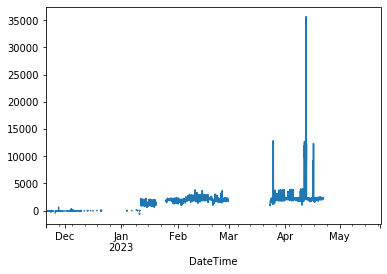

In [10]:
alpha_no2_conc_data.sensor_dataframe['measuring'].plot()

### Plot Valid Data

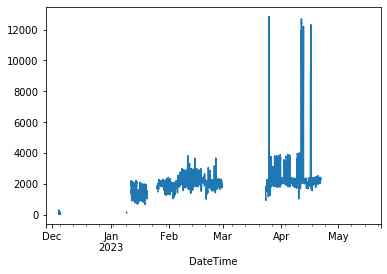

In [11]:
alpha_no2_conc_data.sensor_dataframe[alpha_no2_conc_data.sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()

### Plot raw derivatives

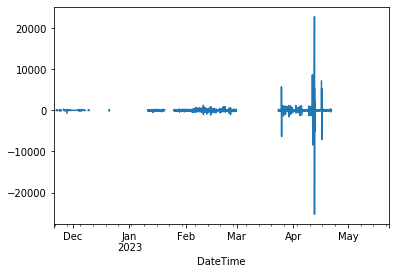

In [12]:
alpha_no2_conc_data.sensor_dataframe['Diff'].resample('15T').mean().plot()

### Plot valid derivatives

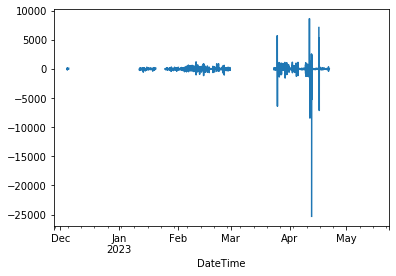

In [13]:
alpha_no2_conc_data.valid_differential_series.resample('15T').mean().plot()

## Resampled data

In [14]:
alpha_no2_conc_data.sensor_dataframe_1hr.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,Tag
DateTime,,,,,,,,,
2022-11-27 16:00:00,593.5,-28.4569,-48.973,NaN,16,1,NaN,25.0,LOWSAMPLES
2022-11-27 17:00:00,NaN,NaN,NaN,NaN,17,0,NaN,0.0,LOWSAMPLES
2022-11-27 18:00:00,NaN,NaN,NaN,NaN,18,0,NaN,0.0,LOWSAMPLES
2022-11-27 19:00:00,NaN,NaN,NaN,NaN,19,0,NaN,0.0,LOWSAMPLES
2022-11-27 20:00:00,NaN,NaN,NaN,NaN,20,0,NaN,0.0,LOWSAMPLES


### Data contabilization

In [15]:
data_contabilization = count_tags(['LOWSAMPLES','VALID'], alpha_no2_conc_data.sensor_dataframe_1hr)
data_contabilization

,#,%
LOWSAMPLES,2526,59.5474
VALID,1716,40.4526
TOTAL,4242,100


### Plot raw hourly data

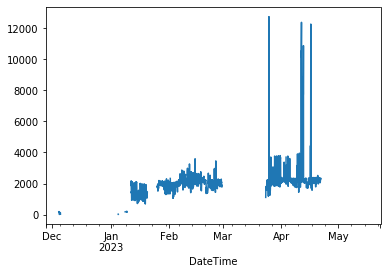

In [16]:
alpha_no2_conc_data.sensor_dataframe_1hr['measuring'].plot()

### Plot valid hourly data

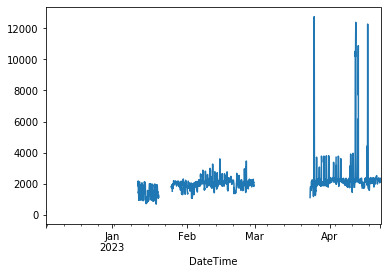

In [17]:
alpha_no2_conc_data.sensor_dataframe_1hr[alpha_no2_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']['measuring'].resample('H').mean().plot()

### Plot raw standard deviation

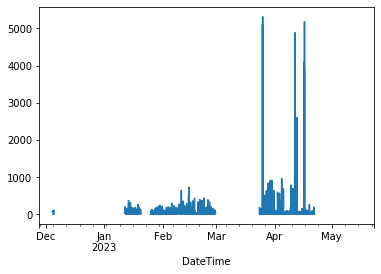

In [18]:
alpha_no2_conc_data.sensor_dataframe_1hr['Std'].resample('H').mean().plot()

### Plot valid standard deviation

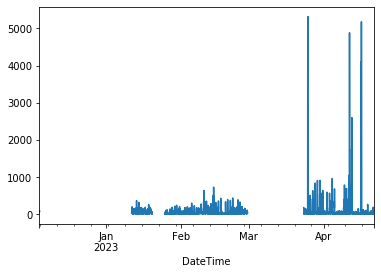

In [19]:
alpha_no2_conc_data.sensor_dataframe_1hr[alpha_no2_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']['Std'].resample('H').mean().plot()

## Calculate quantiles and tag data accordingly

### Calculate quantiles

In [20]:
alpha_no2_conc_data.calculate_and_tag_quantiles()
alpha_no2_conc_data.sensor_dataframe_1hr.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,Tag,GLOBAL_QTLE01,GLOBAL_QTLE99
DateTime,,,,,,,,,,,
2022-11-27 16:00:00,593.5,-28.4569,-48.973,NaN,16,1,NaN,25.0,LOWSAMPLES,190.00,12385.75
2022-11-27 17:00:00,NaN,NaN,NaN,NaN,17,0,NaN,0.0,LOWSAMPLES,192.25,10883.00
2022-11-27 18:00:00,NaN,NaN,NaN,NaN,18,0,NaN,0.0,LOWSAMPLES,1018.50,2599.00
2022-11-27 19:00:00,NaN,NaN,NaN,NaN,19,0,NaN,0.0,LOWSAMPLES,898.50,2559.50
2022-11-27 20:00:00,NaN,NaN,NaN,NaN,20,0,NaN,0.0,LOWSAMPLES,25.25,2545.00


## Process valid hourly data

### Methods definitions

In [21]:
import matplotlib.pyplot as plt

def plot_mean_vs_std(df):
    fig = plt.figure(figsize=(1.3*7,7))
    plt.scatter(df['Std'], df['measuring'], c=df['% valid'], cmap='jet')
    cax = plt.axes([0.95, 0.1, 0.05
                    , 0.8])
    cbar = plt.colorbar(orientation='vertical', cax=cax)
    cbar.ax.tick_params(labelsize=11, length=0)
    ticks = [np.int64(df['% valid'].min() + 1), 
             np.int64((df['% valid'].max() - df['% valid'].min()) / 2),
             np.int64(df['% valid'].max())]
    cbar.set_ticks(np.array(ticks))
    cbar.ax.tick_params(labelsize=15, length=0)

def plot_std_in_time(df):
    fig = plt.figure(figsize=(1.3*7,7))
    plt.scatter(df.index, df['Std'], c=df['% valid'], cmap='jet')
    cax = plt.axes([0.95, 0.1, 0.05, 0.8])
    cbar = plt.colorbar(orientation='vertical', cax=cax)
    cbar.ax.tick_params(labelsize=11, length=0)
    ticks = [np.int64(df['% valid'].min() + 1),
             np.int64((df['% valid'].max() - df['% valid'].min()) / 2),
             np.int64(df['% valid'].max())]
    cbar.set_ticks(np.array(ticks))
    cbar.ax.tick_params(labelsize=15, length=0)

def plot_box_hist(df, bins):
  bottom, height = 0.1, 0.65
  left, width = bottom, height*1.3
  spacing = 0.005
  
  rect_ser = [left-width-spacing, bottom, width, height]
  rect_box = [left, bottom, width, height]
  rect_hist = [left + width + spacing, bottom, height/1.3, height]

  plt.figure(figsize=(5, 5/1.3))

  ax_ser  = plt.axes(rect_ser)
  ax_ser.tick_params(direction='in', top=True, right=True)
  ax_ser.set_title('Serie temporal')

  ax_box  = plt.axes(rect_box)
  ax_box.tick_params(direction='in', labelleft=False)

  ax_hist = plt.axes(rect_hist)
  ax_hist.tick_params(direction='in', labelleft=False)
  ax_hist.set_title('Histograma')

  lim_max = df['measuring'].max()+df['measuring'].max()*10/100
  lim_min = df['measuring'].min()-df['measuring'].min()*10/100

  df['measuring'].plot(ax=ax_ser)
  ax_ser.set_ylim(lim_min, lim_max)

  ax_hist.hist(df['measuring'], bins=bins, orientation='horizontal')
  ax_hist.set_ylim(lim_min, lim_max)

  df = df.dropna(axis='index', how='all', subset=['Hour'])
  df['Hour'] = df['Hour'].astype('int64')
  df.pivot(columns='Hour')['measuring'].dropna(
        axis='columns', how='all').plot.box(
            ax=ax_box,title='Comportamento médio no período')
  ax_box.set_ylim(ax_hist.get_ylim())

In [22]:
dataframe = alpha_no2_conc_data.sensor_dataframe_1hr[alpha_no2_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID'].resample('H').mean()

## Calculate quantiles

In [23]:
global_qtle_01 = dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
dataframe['GLOBAL QTLE01'] = dataframe['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
dataframe['GLOBAL QTLE99'] = dataframe['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
dataframe.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,GLOBAL_QTLE01,GLOBAL_QTLE99,GLOBAL QTLE01,GLOBAL QTLE99
DateTime,,,,,,,,,,,,
2023-01-11 17:00:00,1866.50,-28.4569,-48.973,-47.00,17.0,4.0,40.120651,100.0,192.25,10883.0,1354.50,5082.50
2023-01-11 18:00:00,1965.50,-28.4569,-48.973,62.75,18.0,4.0,103.022651,100.0,1018.50,2599.0,1315.00,2345.75
2023-01-11 19:00:00,2172.75,-28.4569,-48.973,10.25,19.0,4.0,32.836717,100.0,898.50,2559.5,972.25,2389.75
2023-01-11 20:00:00,1674.25,-28.4569,-48.973,-169.50,20.0,4.0,195.575007,100.0,25.25,2545.0,881.00,2385.75
2023-01-11 21:00:00,1380.50,-28.4569,-48.973,-11.25,21.0,4.0,36.097091,100.0,859.75,2549.5,863.75,2387.00


### Plot mean vs. standard deviation for valid hourly data colored by valid percentage of valid samples

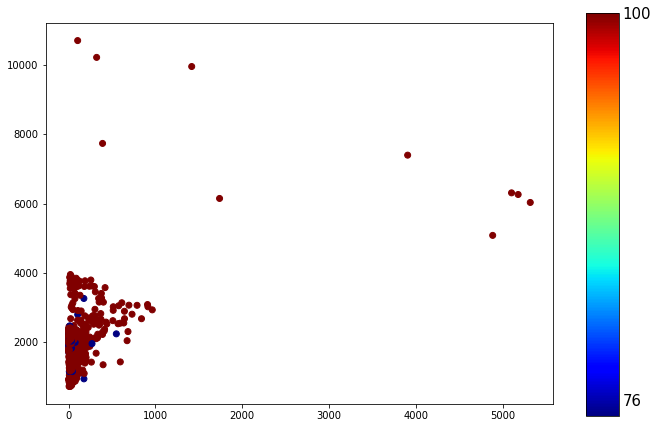

In [24]:
plot_mean_vs_std(dataframe)

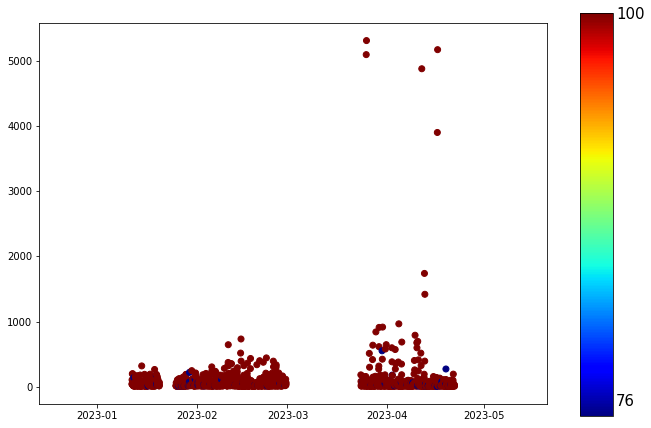

In [25]:
plot_std_in_time(dataframe)

c:\Users\Fernando\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\Fernando\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
c:\Users\Fernando\anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


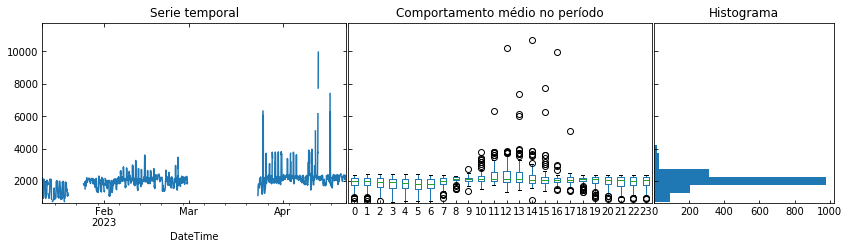

In [26]:
plot_box_hist(dataframe, 20)